# Jedi vs. Sith vs. Neither
A ternary image classifier example

## Goal

The goal of this notebook is to demonstrate the functionality of a ternary image classifier network.

## Architecture

This neural network will use a Convolutional architecture on the Keras neural network framework with TensorFlow as the backend. After training, it will classify images as either 'Jedi' or 'Sith' or 'Neither'.

In [1]:
# Set up TensorFlow
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import random

## Global Parameters

The global parameters are batch size (32) and image size (400x400).

In [3]:
batch_size = 32
img_height = 400
img_width = 400

## Training Dataset

We have a training dataset of hand-curated images in three subdirectories called "jedi", "sith", and "neither". We'll load them here.

### Data Quality

The dataset I'm using came from Kaggle, here: [Star Wars Images | Kaggle](https://www.kaggle.com/datasets/mathurinache/star-wars-images).

Note that Obi-Wan Kenobi is, for some reason, split into "Kenobi" and "Obi-Wan" directories. Note also that there are non-Star Wars images in some of the directories. For example, there are pictures of Edgar Allan Poe in Poe Dameron's directory. Inexplicably, there's a picture of Hermione Granger in Orson Krennic's directory.

I'm leaving these in as neither Edger Allan Poe, nor Hermione Granger are Jedi or Sith, therefore they can reasonably be called "neither".

Rey has the unfortunate coincidence of sharing her name with a famous _luchador_ so there are photos of him in her directory. Those I'm removing because El Rey is _not_ a Jedi. I've also removed all the photos of Finn from his Stormtrooper days since he's indistinguishable from any other Stormtrooper when wearing his helmet and I didn't want to confuse the model.

In [4]:
data_dir = pathlib.Path('training_set_ternary')

jedi = list(data_dir.glob('jedi/*'))
sith = list(data_dir.glob('sith/*'))
neither = list(data_dir.glob('neither/*'))
num_jedi = len(jedi)
num_sith = len(sith)
num_neither = len(neither)
total_count = num_jedi + num_sith + num_neither

print(num_jedi, 'Jedi images, ', num_sith, 'Sith images, and ', num_neither, 'Neither images')

745 Jedi images,  637 Sith images, and  3142 Neither images


A Jedi looks like this:


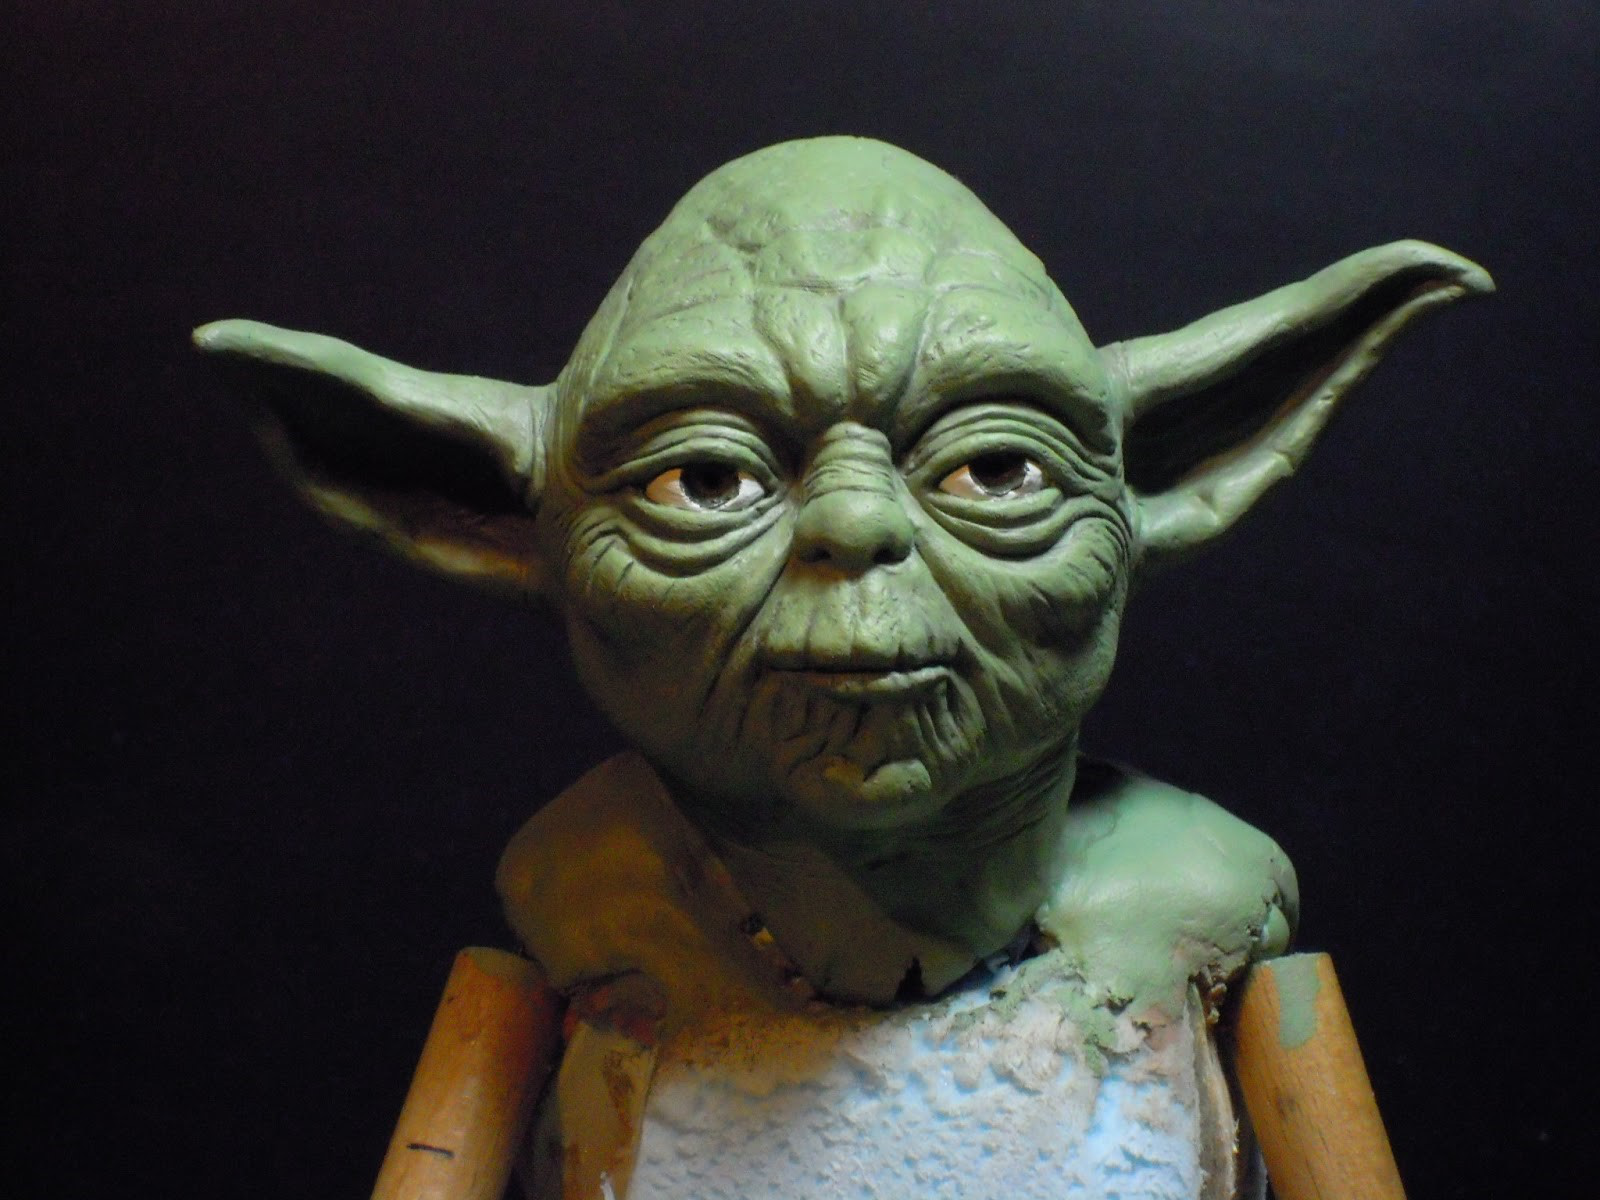

In [5]:
print('A Jedi looks like this:')
PIL.Image.open(jedi[random.randint(0,num_jedi)])

A Sith looks like this:


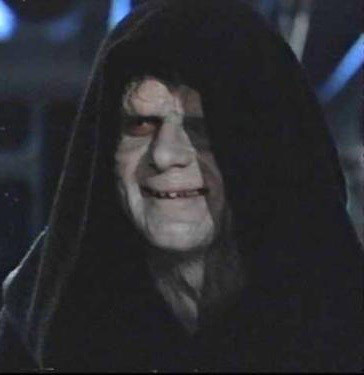

In [6]:
print('A Sith looks like this:')
PIL.Image.open(sith[random.randint(0,num_sith)])

These people are neither Jedi nor Sith:


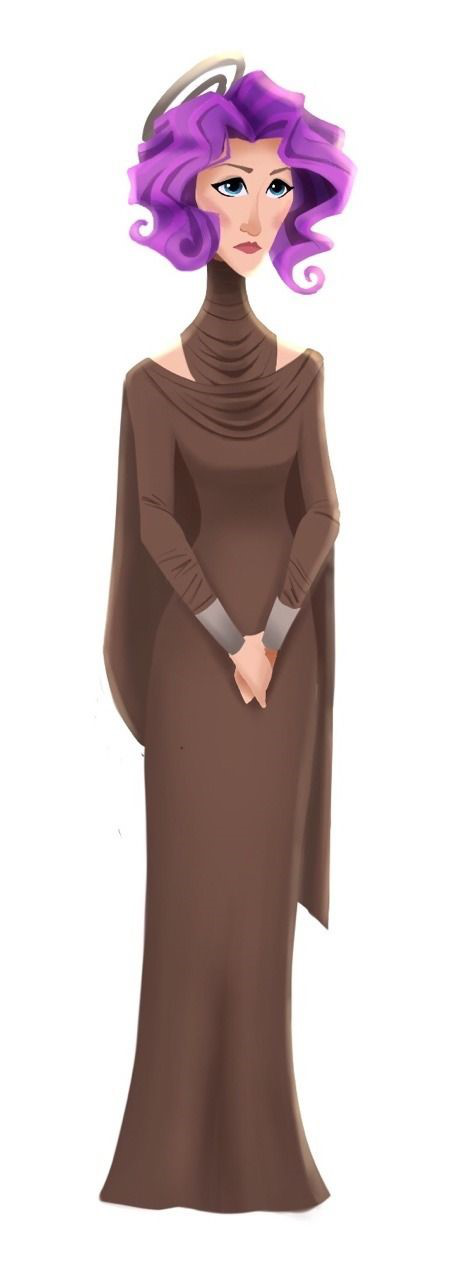

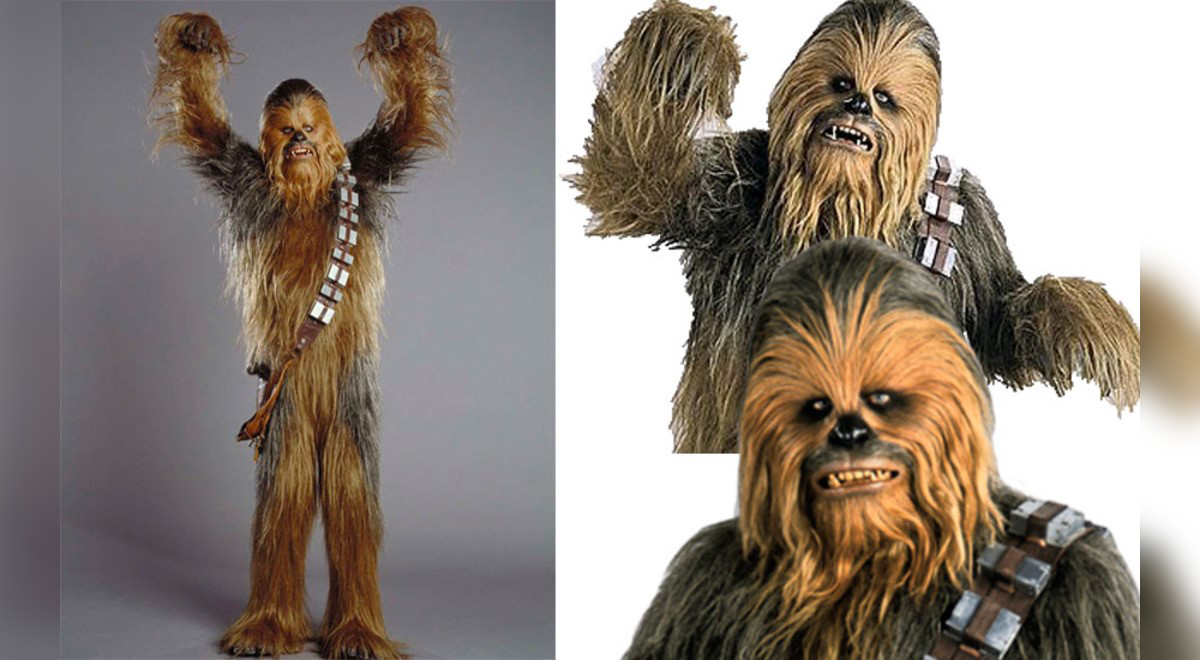

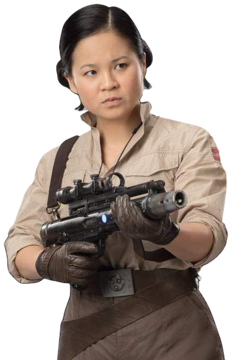

In [7]:
print('These people are neither Jedi nor Sith:')
display(PIL.Image.open(neither[random.randint(0,num_neither)]))
display(PIL.Image.open(neither[random.randint(0,num_neither)]))
display(PIL.Image.open(neither[random.randint(0,num_neither)]))

In [8]:
# Create a dataset from the input images, using 80% for training and 20% for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=213,
    image_size=(img_height,img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

Found 4524 files belonging to 3 classes.
Using 3620 files for training.


2022-08-04 11:49:03.153800: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 11:49:04.008825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6145 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=213,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 4524 files belonging to 3 classes.
Using 904 files for validation.


## I/O Tuning

We'll use the AUTOTUNE feature of `tf.data` to tune the I/O performance parameters.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

The network model is a sequence of layers of convolutions alternating with max pooling functions. Each convolution layer produces a feature map as an output. The max pooling layers reduce the size of each feature map to maximize the magnitude of the observed features. The final layers are "fully-connected" layers, meaning they form a proper deep neural net.

Conceptually, we can think of it as a two-layer model: Convolutions to produce feature maps, which are exaggerated impressions of prominent features of the image, and a neural net that looks at the features and finds patterns in them.

In [11]:
model = tf.keras.Sequential()

### Layer 0: Data Augmentation

Since we have so few training images to work with, we will use some data augmentation techniques built into TensorFlow to pad out our learning dataset.

The first layer is an input layer. Since our images are 400x400px color images, we need an input tensor shape of 400x400x3. This layer will randomly flip the image horizontally, vertically, both, or none.

The second layer will randomly rotate the image left or right by up to 20%.

The third layer will randomly adjust the contrast by 20%.

The fourth layer will randomly zoom into a part of the image by 20-30%.

In [12]:
model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical",
                                 input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.RandomRotation(0.2))
model.add(tf.keras.layers.RandomContrast(0.2))
model.add(tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2)))

### Layer 0.5 Data Normalization

Neurons operate best on values between 0 and 1. Let's remap the color values to that domain from their current range of 0-255.

In [13]:
model.add(tf.keras.layers.Rescaling(1./255))

### Layer 1: Input Convolution

We'll use a ReLU activation function so we deliberately fail to backpropagate any negative bias, which saves us a bit of computational overhead. We'll use 16 filters to start with and a 3x3 kernel, which are good values to use unless you have good reason to use other ones (see many, many papers on why 3x3 is the optimal kernel size for pretty much any CNN).

In [14]:
model.add(tf.keras.layers.Conv2D(16,
                                 (3,3),
                                 activation='relu'))

### Layer 2: Dropout

To reduce overfitting, we will randomly knock out 1/5 of the neurons in the network.

In [15]:
model.add(tf.keras.layers.Dropout(rate=0.2))

### Layer 3: Max Pooling

Takes the output of the previous layer (a feature map) and pools each quadrant, taking the maximum value thereof.

In [16]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 4: Second Convolution

Convolves the maximized pooled feature map from Layer 1, using 32 filters this time, and still using a ReLU activation function to eliminate negative values.

In [17]:
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))

### Layer 5: Max Pooling

Another max pooling layer to separate the convolutions like thin paper sheets separate deli slices.

In [18]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 6: Third Convolution

This time, we're bumping the filters up to 64, because want to learn more from less input data.

In [19]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 7: Max Pooling

You guessed it, another max pooling layer

In [20]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 8: Fourth Convolution

Same as the third.

In [21]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 9: Max Pooling

Lather, rinse, repeat.

In [22]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 10: Fifth Convolution

Same as the third and fourth.

In [23]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 11: Max Pooling

Last one.

In [24]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 12: Flattening

The output shape of the last max pooling layer is 10x10x64. Since we want to learn from our feature map by using a Dense Neural Net layer, we need to flatten our 3 dimensional tensor into a 1-dimensional vector. 10 times 10 is 100 and 100 times 64 is 6400. Therefore, the input to our DNN will be a vector containing 6400 terms.

In [25]:
model.add(tf.keras.layers.Flatten())

### Layer 13: Dropout

To reduce overfitting, we will randomly knock out 1/5 of the neurons in the network.

In [26]:
model.add(tf.keras.layers.Dropout(rate=0.2))

### Layer 14: Dense Neural Net

This is the layer that actually _makes inferences_ about the input data, recognizing connections between data points. We're again using ReLU as the activation function to prevent backpropagation of negative bias, which adds complexity to the computation. We're using 3,201 neurons this time. (Input is 6400 data points, output is 3 data points, mean of those two is 3201.)

In [27]:
model.add(tf.keras.layers.Dense(3201, activation='relu'))

### Layer 15: Dropout

To reduce overfitting, we will randomly knock out 2/5 of the neurons in the network.

In [28]:
model.add(tf.keras.layers.Dropout(rate=0.4))

### Layer 16: Ouput DNN

Our final layer is a dense neural network consisting of three neurons. This layer takes the 3201 values from the previous layer and makes the final call, applying a softmax function to represent the probability of membership in each of the three possible classes.

(Fun fact: we really should be using an argmax function, but the discontinuity causes the derivative of the function to be zero, which would mean that the weight fails to update during backpropagation, so we use a "softer" maximum function instead, which accomplishes the same thing after rounding.)

In [29]:
model.add(tf.keras.layers.Dense(3, activation='softmax'))

### Model Summary

16 layers this time (we added some dropouts and augmentation layers) and ready to rock!

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 400, 400, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 400, 400, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 400, 400, 3)      0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 400, 400, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 16)      4

## Detour into Feature Maps

We're going to create a second model that outputs the feature maps from each of the convolution layers when we ask it to predict.

In [31]:
conv_layer_idx = [5, 8, 10, 12, 14]
feature_outputs = [model.layers[i].output for i in conv_layer_idx]
feature_model = tf.keras.Model(inputs=model.inputs, outputs=feature_outputs)

### Class Weights

An additional hyperparameter for this network will be relative class weights. Without this, the model has nearly a 3 to 1 chance of predicting 'neither' before even *looking* at an image. Adding relative weighting evens those odds a bit.

In [32]:
jedi_weight = (1 / num_jedi) * (total_count / 2.0)
neither_weight = (1 / num_neither) * (total_count / 2.0)
sith_weight = (1 / num_sith) * (total_count / 2.0)

class_weight = {0: jedi_weight, 1: neither_weight, 2: sith_weight}

## Training

Our model will be trained by minimizing the cross-entropy loss function.

Cross-entropy loss function:
$$
H(p,q) = - \sum_i{p_i \log q_i} = -y \log \hat{y} - (1 - y)\log(1-\hat{y})
$$
where $y$ is the dependent variable, per category ("Jedi-ness", "Sith-ness", or "Neither-ness"), $p$ is the probability that the image shows a member of said category, and $q$ is the *estimated* probability that the image shows a member of said category. The formula relates the magnitude ($H$) of how far off the mark the guess ($q$) was from the real value ($p$).

We will be applying the ~~Root Mean Square Propagation (RMSProp) optimizer~~ Adam optimizer function to adjust learning rate dynamically, because naïve RMSE propagation would be unduly affected by our class weighting, $\mathbf{w}$, and we want it to be neutral. [Adam](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) does that for us. It's basically RMSProp with an added momentum term and continually-updated bias correction.

In [33]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

### Train yourself to let go of everything you fear to lose.

A more complex problem needs more training. We'll train for 95 epochs.

In [34]:
history = model.fit(
    train_ds,
    epochs=95,
    verbose=1,
    validation_data=val_ds,
    class_weight=class_weight,
)

Epoch 1/95


2022-08-04 11:49:07.452922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


114/114 [==============================] - 22s 140ms/step - loss: 1.5725 - accuracy: 0.3182 - val_loss: 1.2004 - val_accuracy: 0.2976
Epoch 2/95
114/114 [==============================] - 11s 95ms/step - loss: 1.3393 - accuracy: 0.4047 - val_loss: 1.2961 - val_accuracy: 0.2965
Epoch 3/95
114/114 [==============================] - 11s 93ms/step - loss: 1.3486 - accuracy: 0.4185 - val_loss: 1.2017 - val_accuracy: 0.3772
Epoch 4/95
114/114 [==============================] - 11s 93ms/step - loss: 1.3034 - accuracy: 0.4323 - val_loss: 1.1117 - val_accuracy: 0.3927
Epoch 5/95
114/114 [==============================] - 10s 92ms/step - loss: 1.2916 - accuracy: 0.4417 - val_loss: 1.0885 - val_accuracy: 0.4347
Epoch 6/95
114/114 [==============================] - 11s 93ms/step - loss: 1.2945 - accuracy: 0.4475 - val_loss: 1.3642 - val_accuracy: 0.3418
Epoch 7/95
114/114 [==============================] - 10s 92ms/step - loss: 1.2642 - accuracy: 0.4707 - val_loss: 1.1276 - val_accuracy: 0.4259
Ep

114/114 [==============================] - 11s 93ms/step - loss: 0.8575 - accuracy: 0.6840 - val_loss: 0.7415 - val_accuracy: 0.7146
Epoch 58/95
114/114 [==============================] - 10s 92ms/step - loss: 0.8877 - accuracy: 0.6721 - val_loss: 0.6041 - val_accuracy: 0.7611
Epoch 59/95
114/114 [==============================] - 11s 93ms/step - loss: 0.8364 - accuracy: 0.6936 - val_loss: 0.6309 - val_accuracy: 0.7124
Epoch 60/95
114/114 [==============================] - 11s 94ms/step - loss: 0.8196 - accuracy: 0.6876 - val_loss: 0.6887 - val_accuracy: 0.7157
Epoch 61/95
114/114 [==============================] - 11s 94ms/step - loss: 0.8150 - accuracy: 0.7030 - val_loss: 0.6990 - val_accuracy: 0.6770
Epoch 62/95
114/114 [==============================] - 10s 91ms/step - loss: 0.8302 - accuracy: 0.6912 - val_loss: 0.6619 - val_accuracy: 0.7146
Epoch 63/95
114/114 [==============================] - 10s 92ms/step - loss: 0.8126 - accuracy: 0.6925 - val_loss: 0.6469 - val_accuracy: 0.71

## Jedi, Sith, or Neither?

Now let's give it our own images and see if it thinks the image shows a Jedi, a Sith, or neither one.

In [35]:
import ipywidgets as widgets
import io

uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

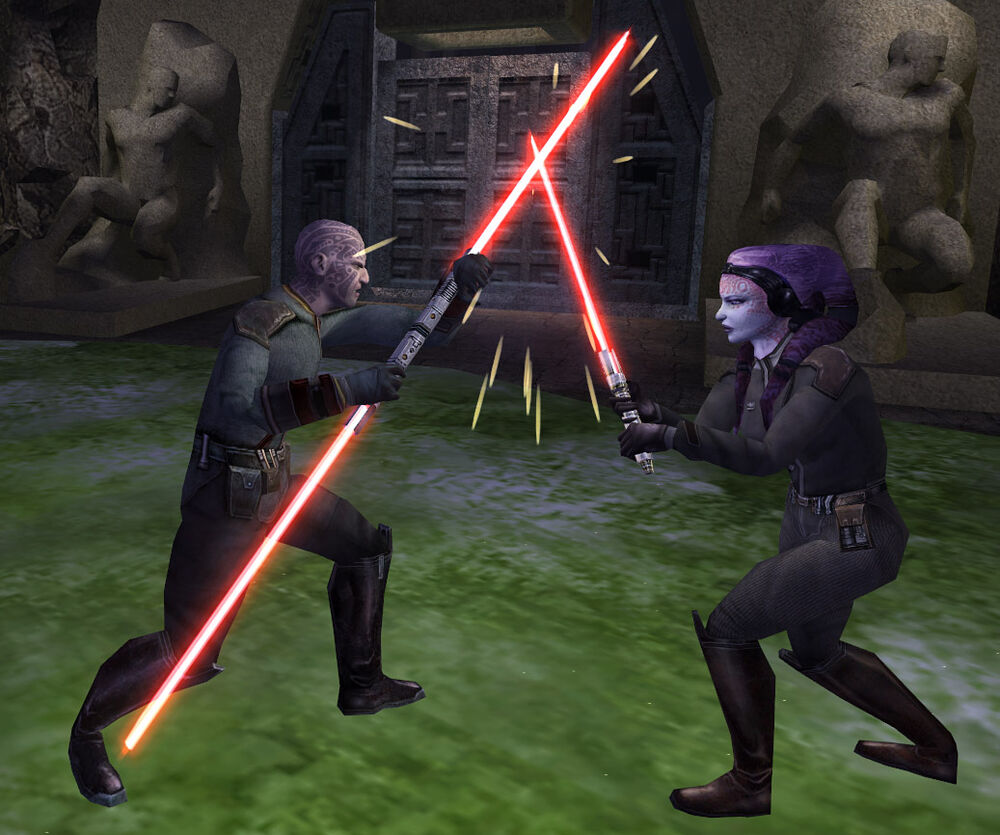

In [107]:
for name, file_info in uploader.value.items():
    our_image = PIL.Image.open(io.BytesIO(file_info['content']))
    
our_image

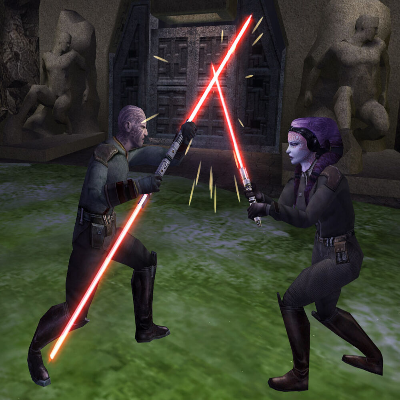

In [108]:
our_image = PIL.Image.open(io.BytesIO(file_info['content']))
our_image = tf.image.resize(our_image, [img_height,img_width])
our_image_array = our_image[:,:,:3] # discard alpha channel
tf.keras.utils.array_to_img(our_image_array)

In [109]:
our_image_array = tf.expand_dims(our_image_array, 0) # Create a batch of a single image

In [110]:
our_predictions = model.predict(our_image_array)

print(f"{our_predictions[0][0]:.0%} likelihood that this is a picture of a {class_names[0]}, {our_predictions[0][2]:.0%} likelihood that this is a picture of a {class_names[2]}, and {our_predictions[0][1]:.0%} likelihood that this picture shows {class_names[1]} a {class_names[0]} nor a {class_names[2]}.")

3% likelihood that this is a picture of a jedi, 89% likelihood that this is a picture of a sith, and 9% likelihood that this picture shows neither a jedi nor a sith.


### How did our model see this image?

We'll ask the second model (`feature_model`) to make a prediction here, which you recall, causes it to output the feature maps.

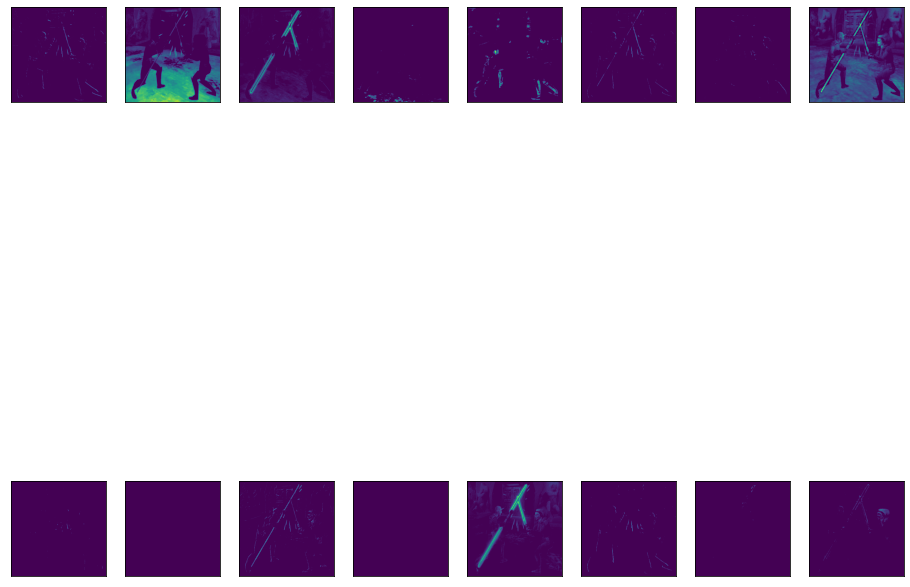

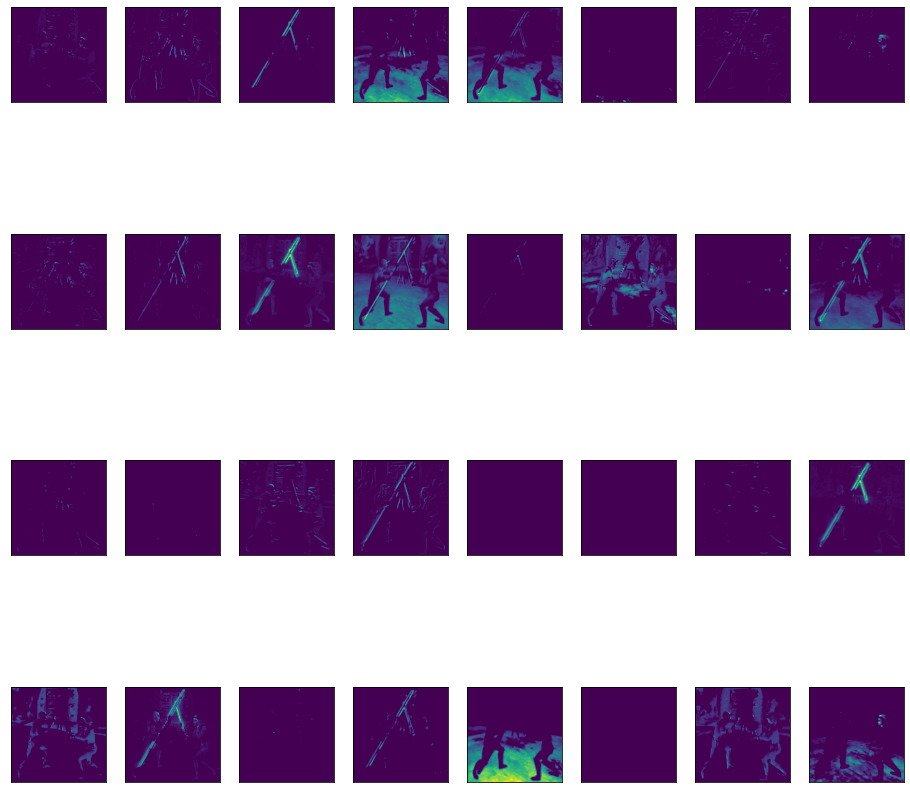

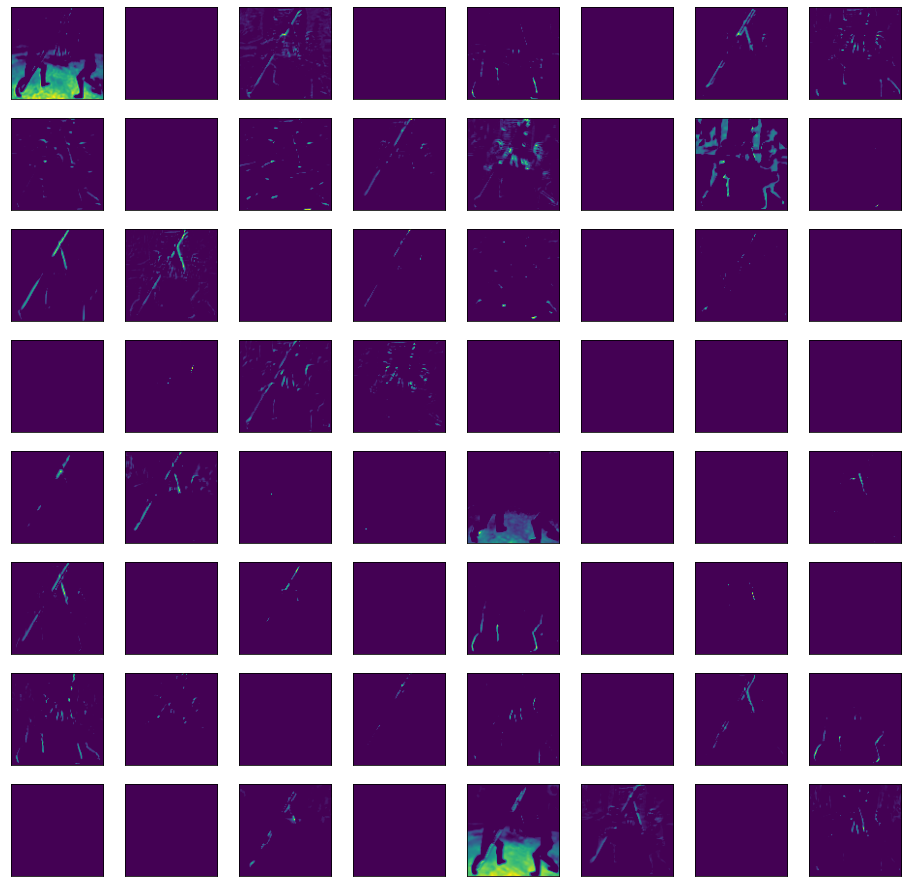

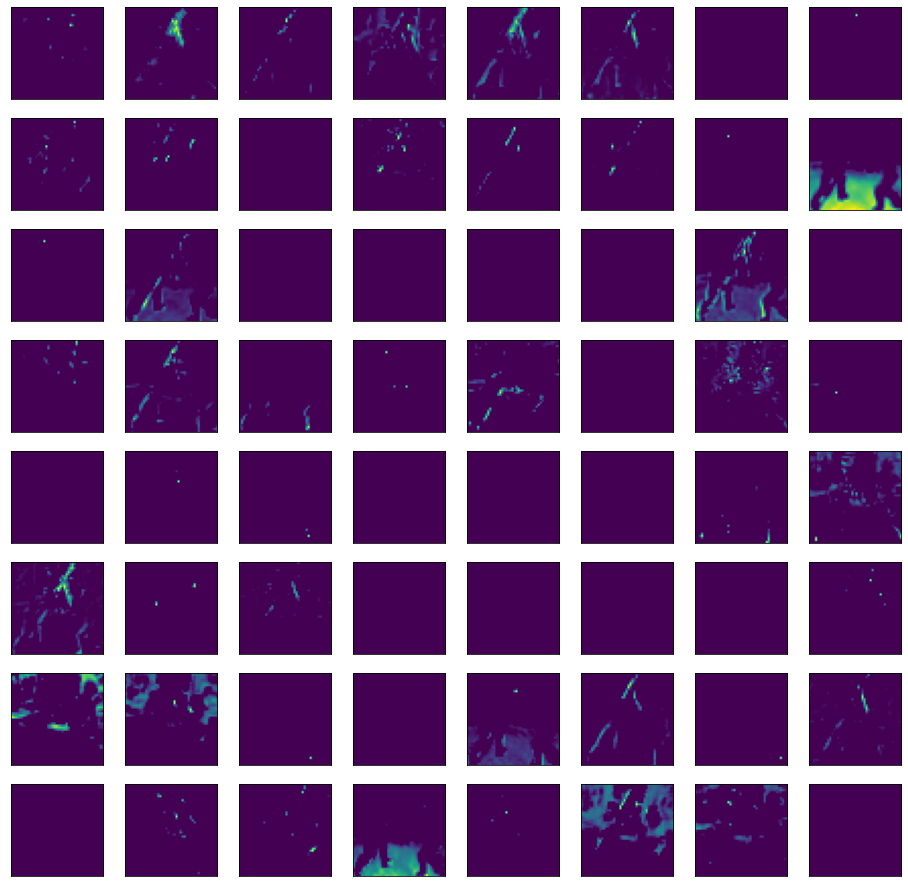

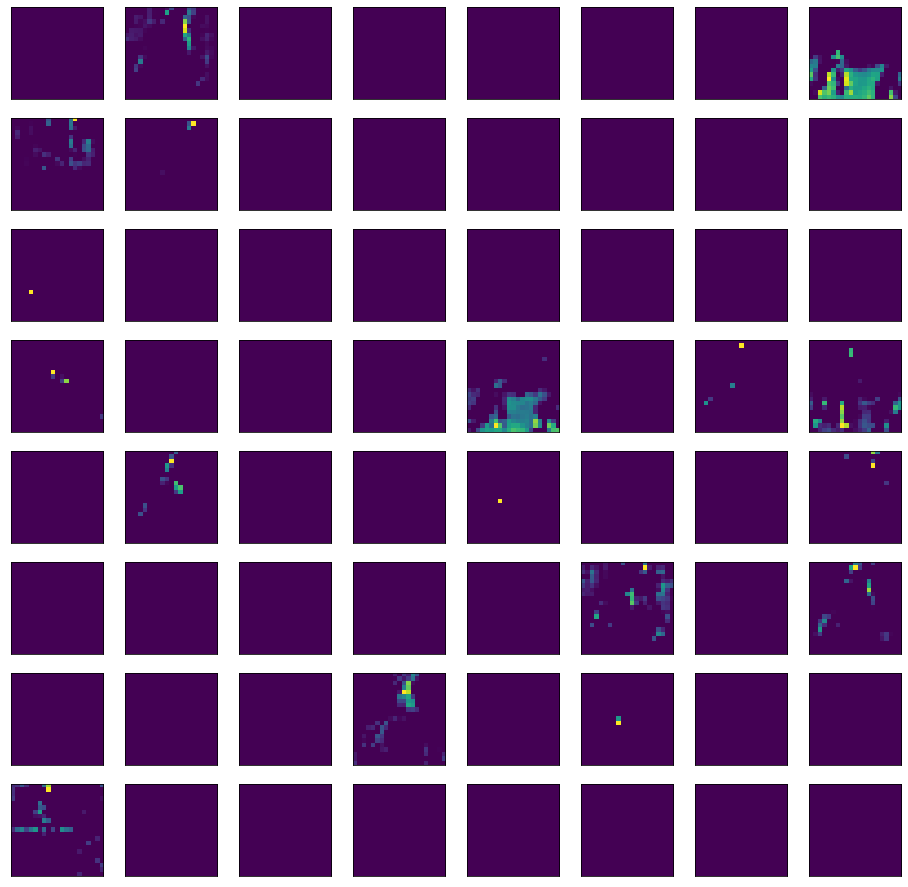

In [111]:
from matplotlib import pyplot

feature_maps = feature_model.predict(our_image_array)
sizes = [16, 32, 64, 64, 64]
row_size = 8

for map_index, feature_map in enumerate(feature_maps):
    current_index = 1
    num_rows = int(sizes[map_index]/row_size)
    figure = pyplot.figure(figsize=(16,16))
    
    for row in range(num_rows):
        for column in range(row_size):
            ax = figure.add_subplot(num_rows, row_size, current_index)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # use grayscale filter
            pyplot.imshow(feature_map[0, :, :, current_index-1])
            current_index += 1
            
    # show the plot
    pyplot.show()